In [26]:
import pandas as pd
import numpy as np
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import normalize
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import optuna
import joblib
import shap

In [2]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\ML course\WildBlueberry_YieldPrediction_Project3\Data\WildBlueberryPollinationSimulationData.csv")
df.head()

Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0    0     37.5       0.75     0.25     0.25    0.25         86.0         
1    1     37.5       0.75     0.25     0.25    0.25         86.0         
2    2     37.5       0.75     0.25     0.25    0.25         94.6         
3    3     37.5       0.75     0.25     0.25    0.25         94.6         
4    4     37.5       0.75     0.25     0.25    0.25         86.0         

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0        52.0                71.9                62.0              30.0         
1        52.0                71.9                62.0              30.0         
2        57.2                79.0                68.2              33.0         
3        57.2                79.0                68.2              33.0         
4        52.0                71.9                62.0              30.0         

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0          50.8             16.0             0.26         0.410652  0.408159    
1          50.8              1.0             0.10         0.444254  0.425458    
2          55.9             16.0             0.26         0.383787  0.399172    
3          55.9              1.0             0.10         0.407564  0.408789    
4          50.8             24.0             0.39         0.354413  0.382703    

     seeds       yield     
0  31.678898  3813.165795  
1  33.449385  4947.605663  
2  30.546306  3866.798965  
3  31.562586  4303.943030  
4  28.873714  3436.493543

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [4]:
# Drop the row no. column as it is redundant
# Drop fruitset, fruitmass and seeds are atttributes of yield, hence they need to be removed
df.drop(columns = ['Row#','fruitset','fruitmass','seeds'], inplace = True)
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
yield                   0
dtype: int64

Shape of your Data Set loaded: (777, 14)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  13
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    13 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Regression problem #####################
To fix these data quality issues i

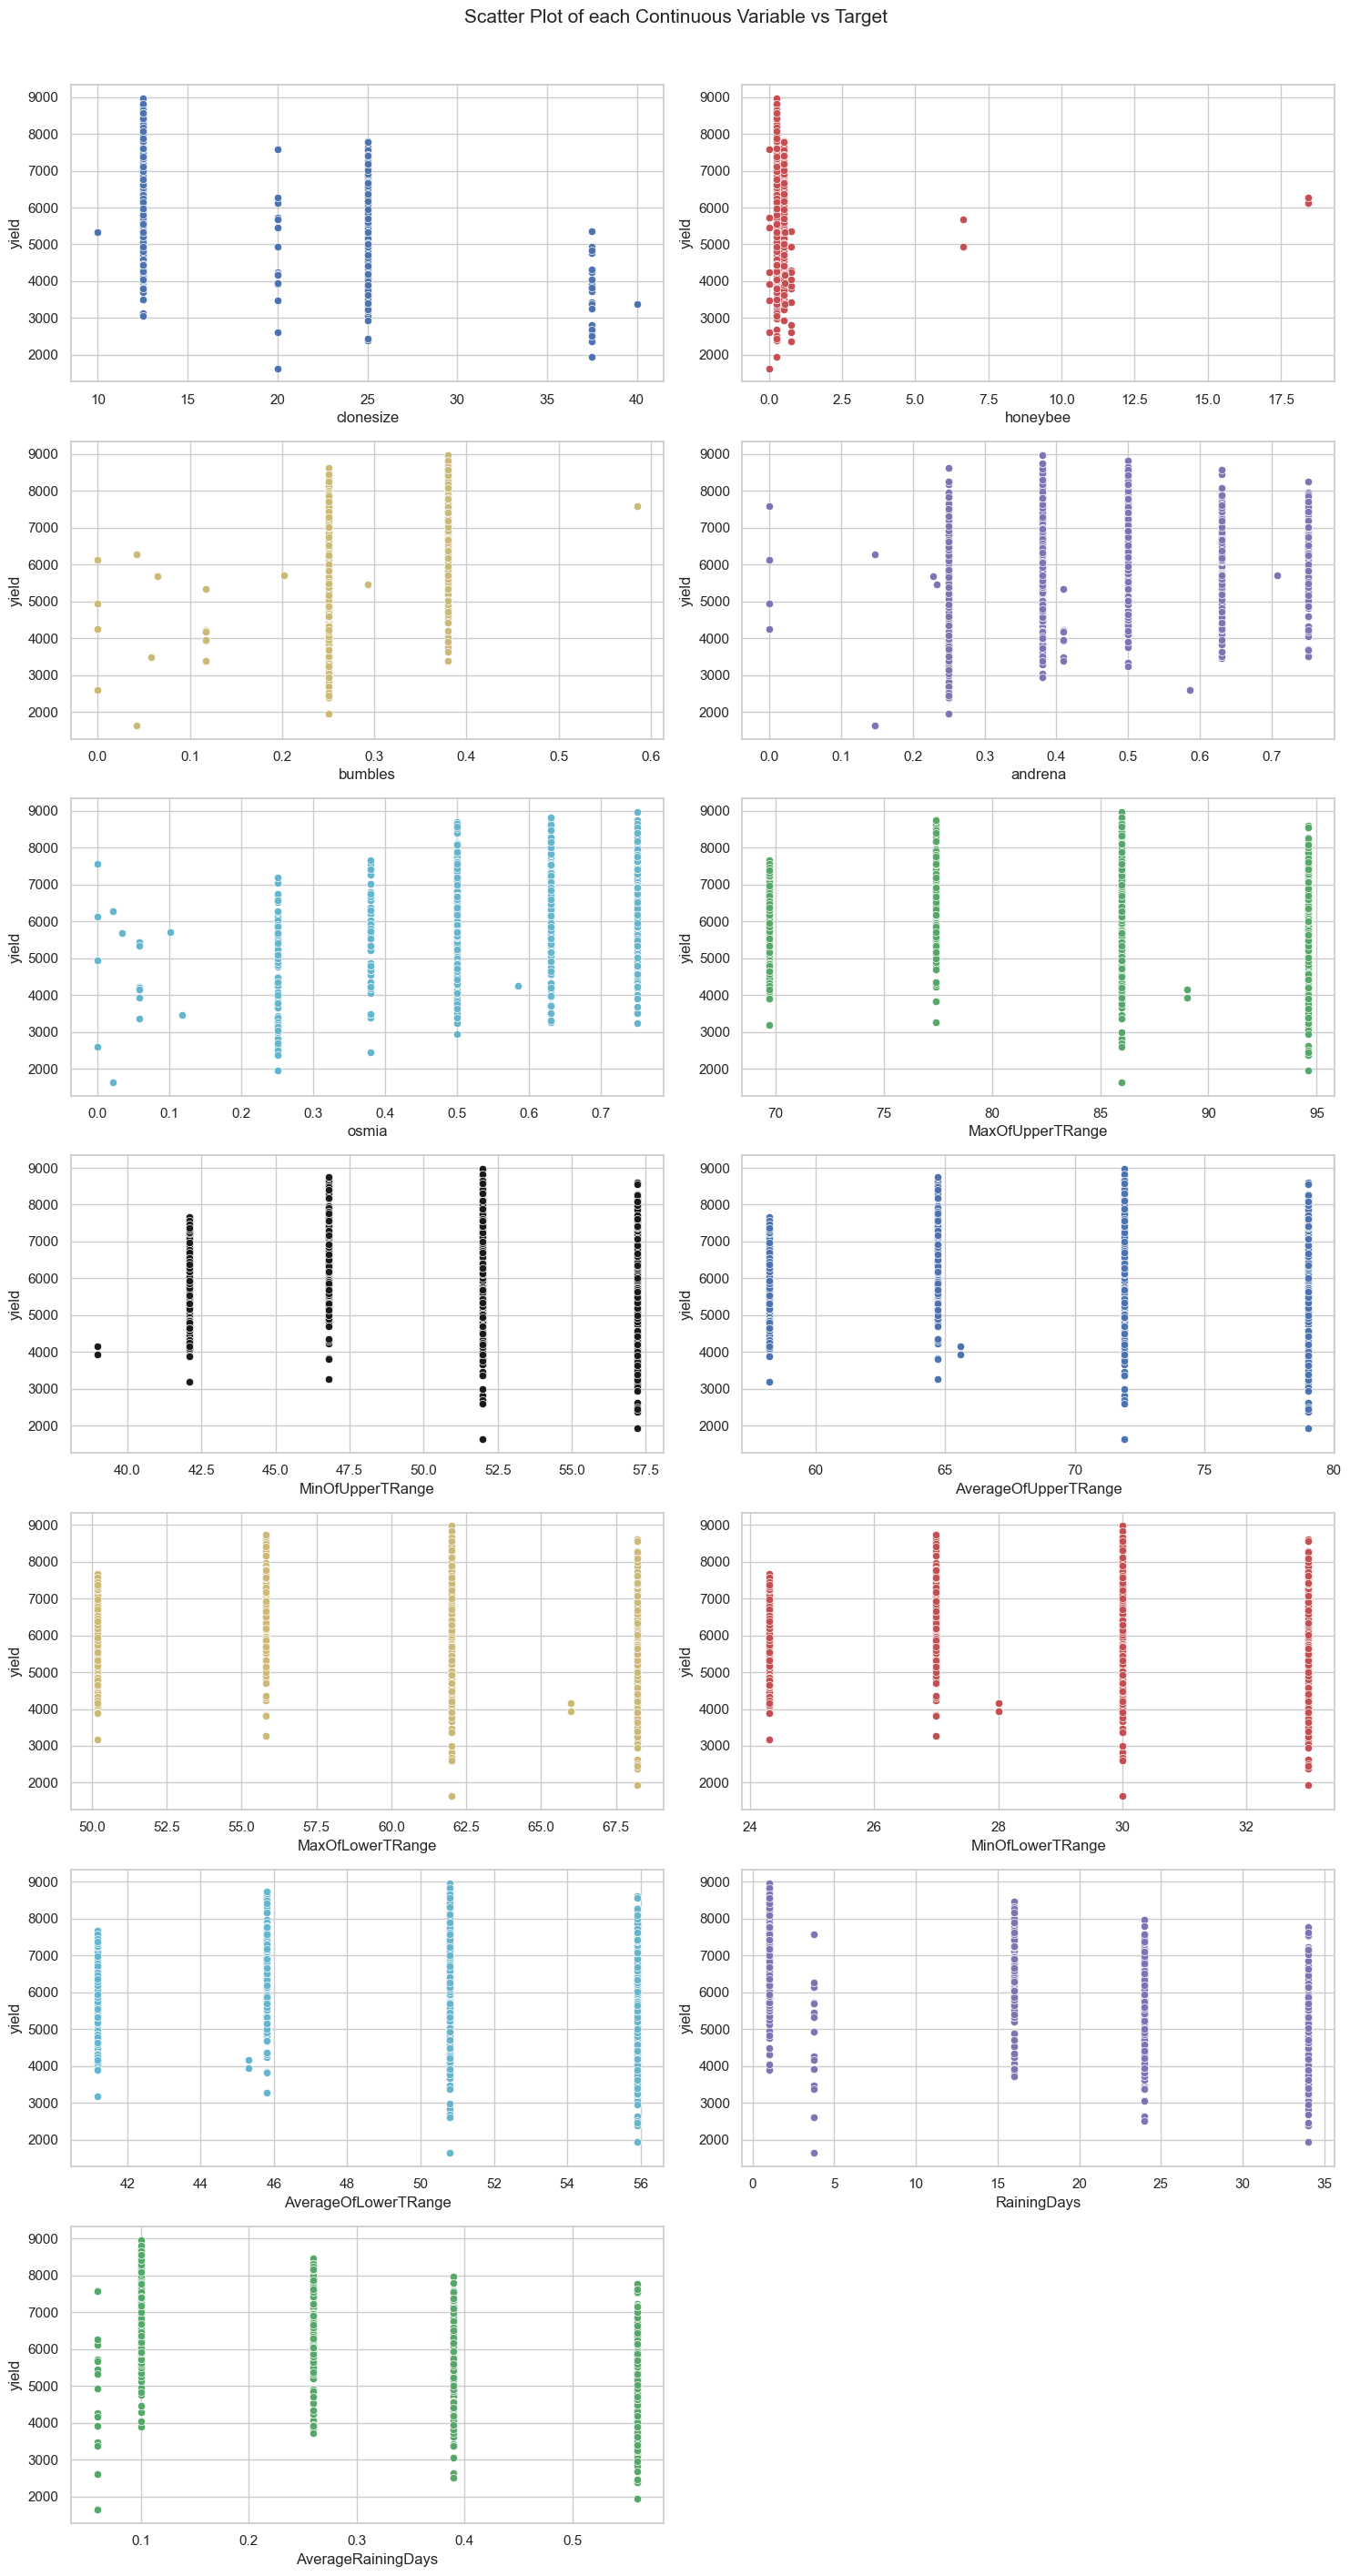

Number of All Scatter Plots = 91


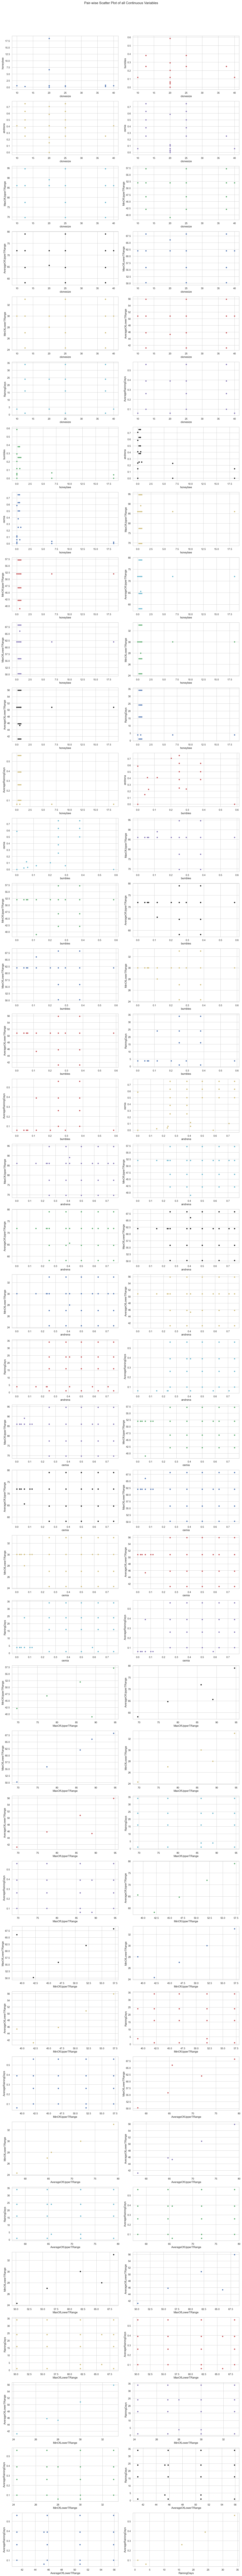

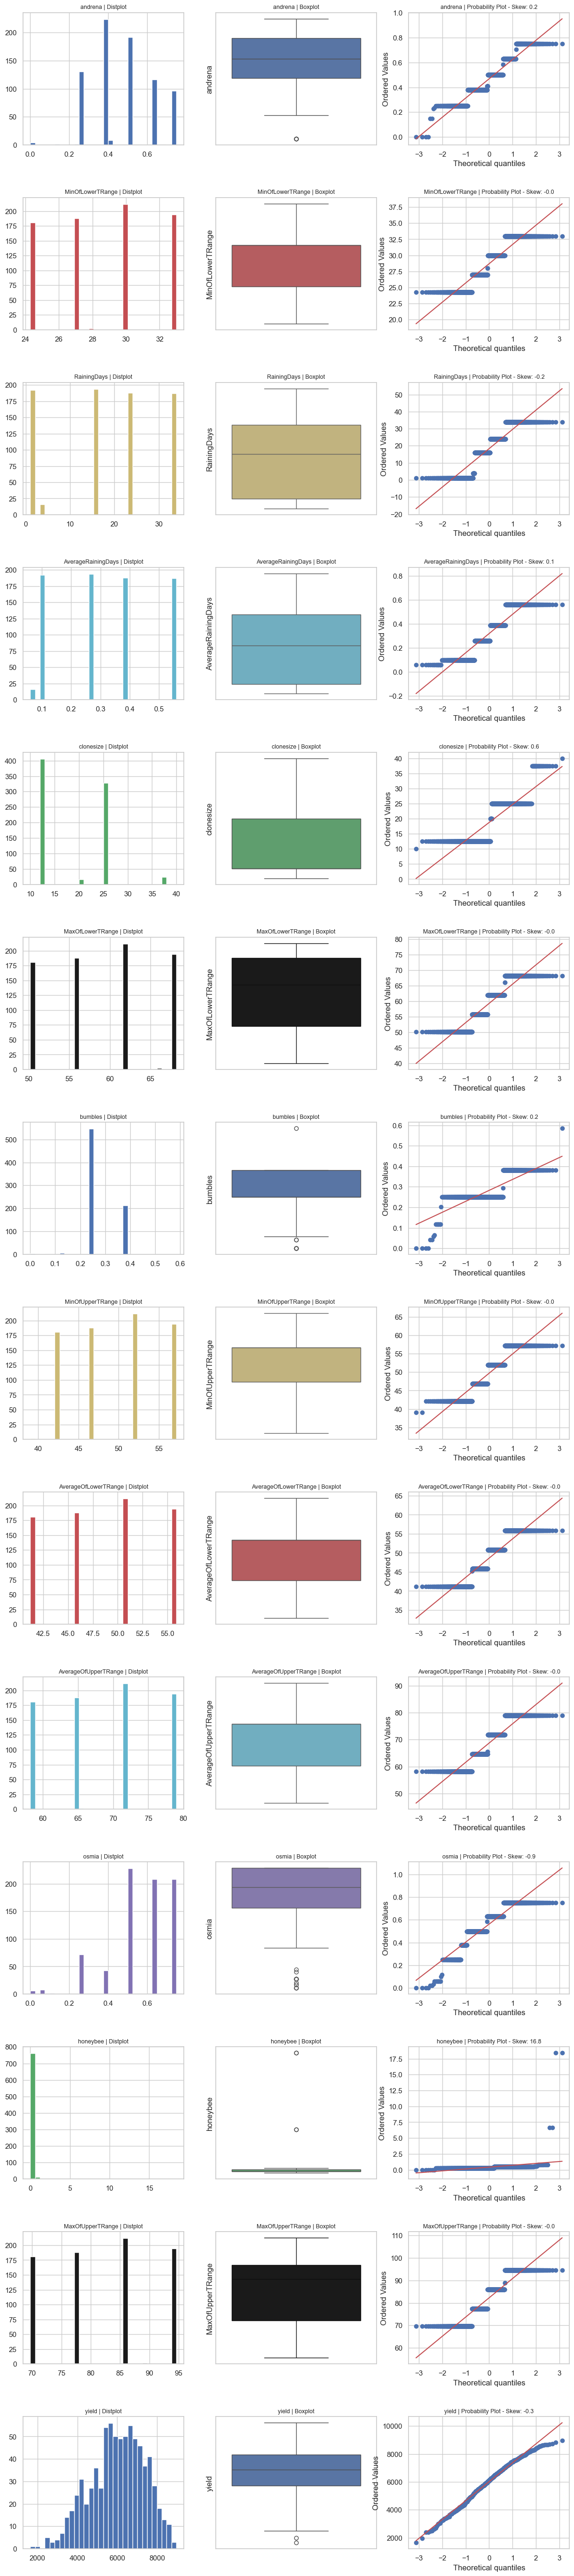

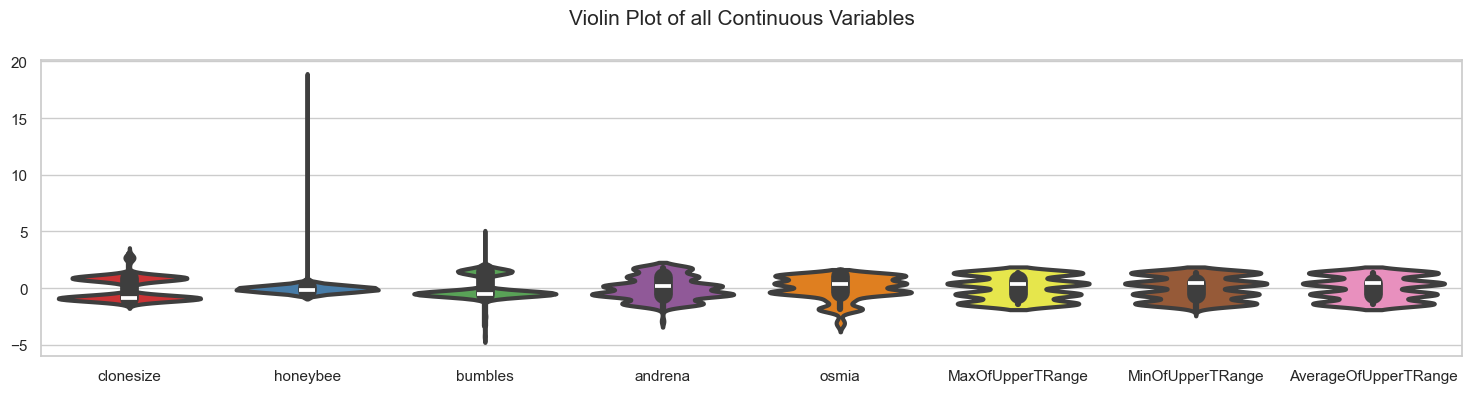

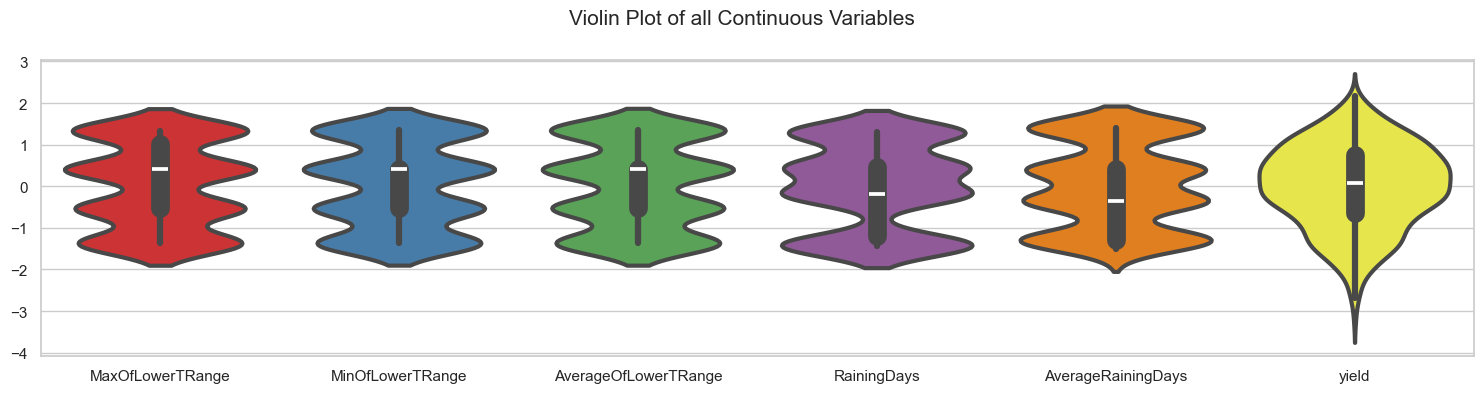

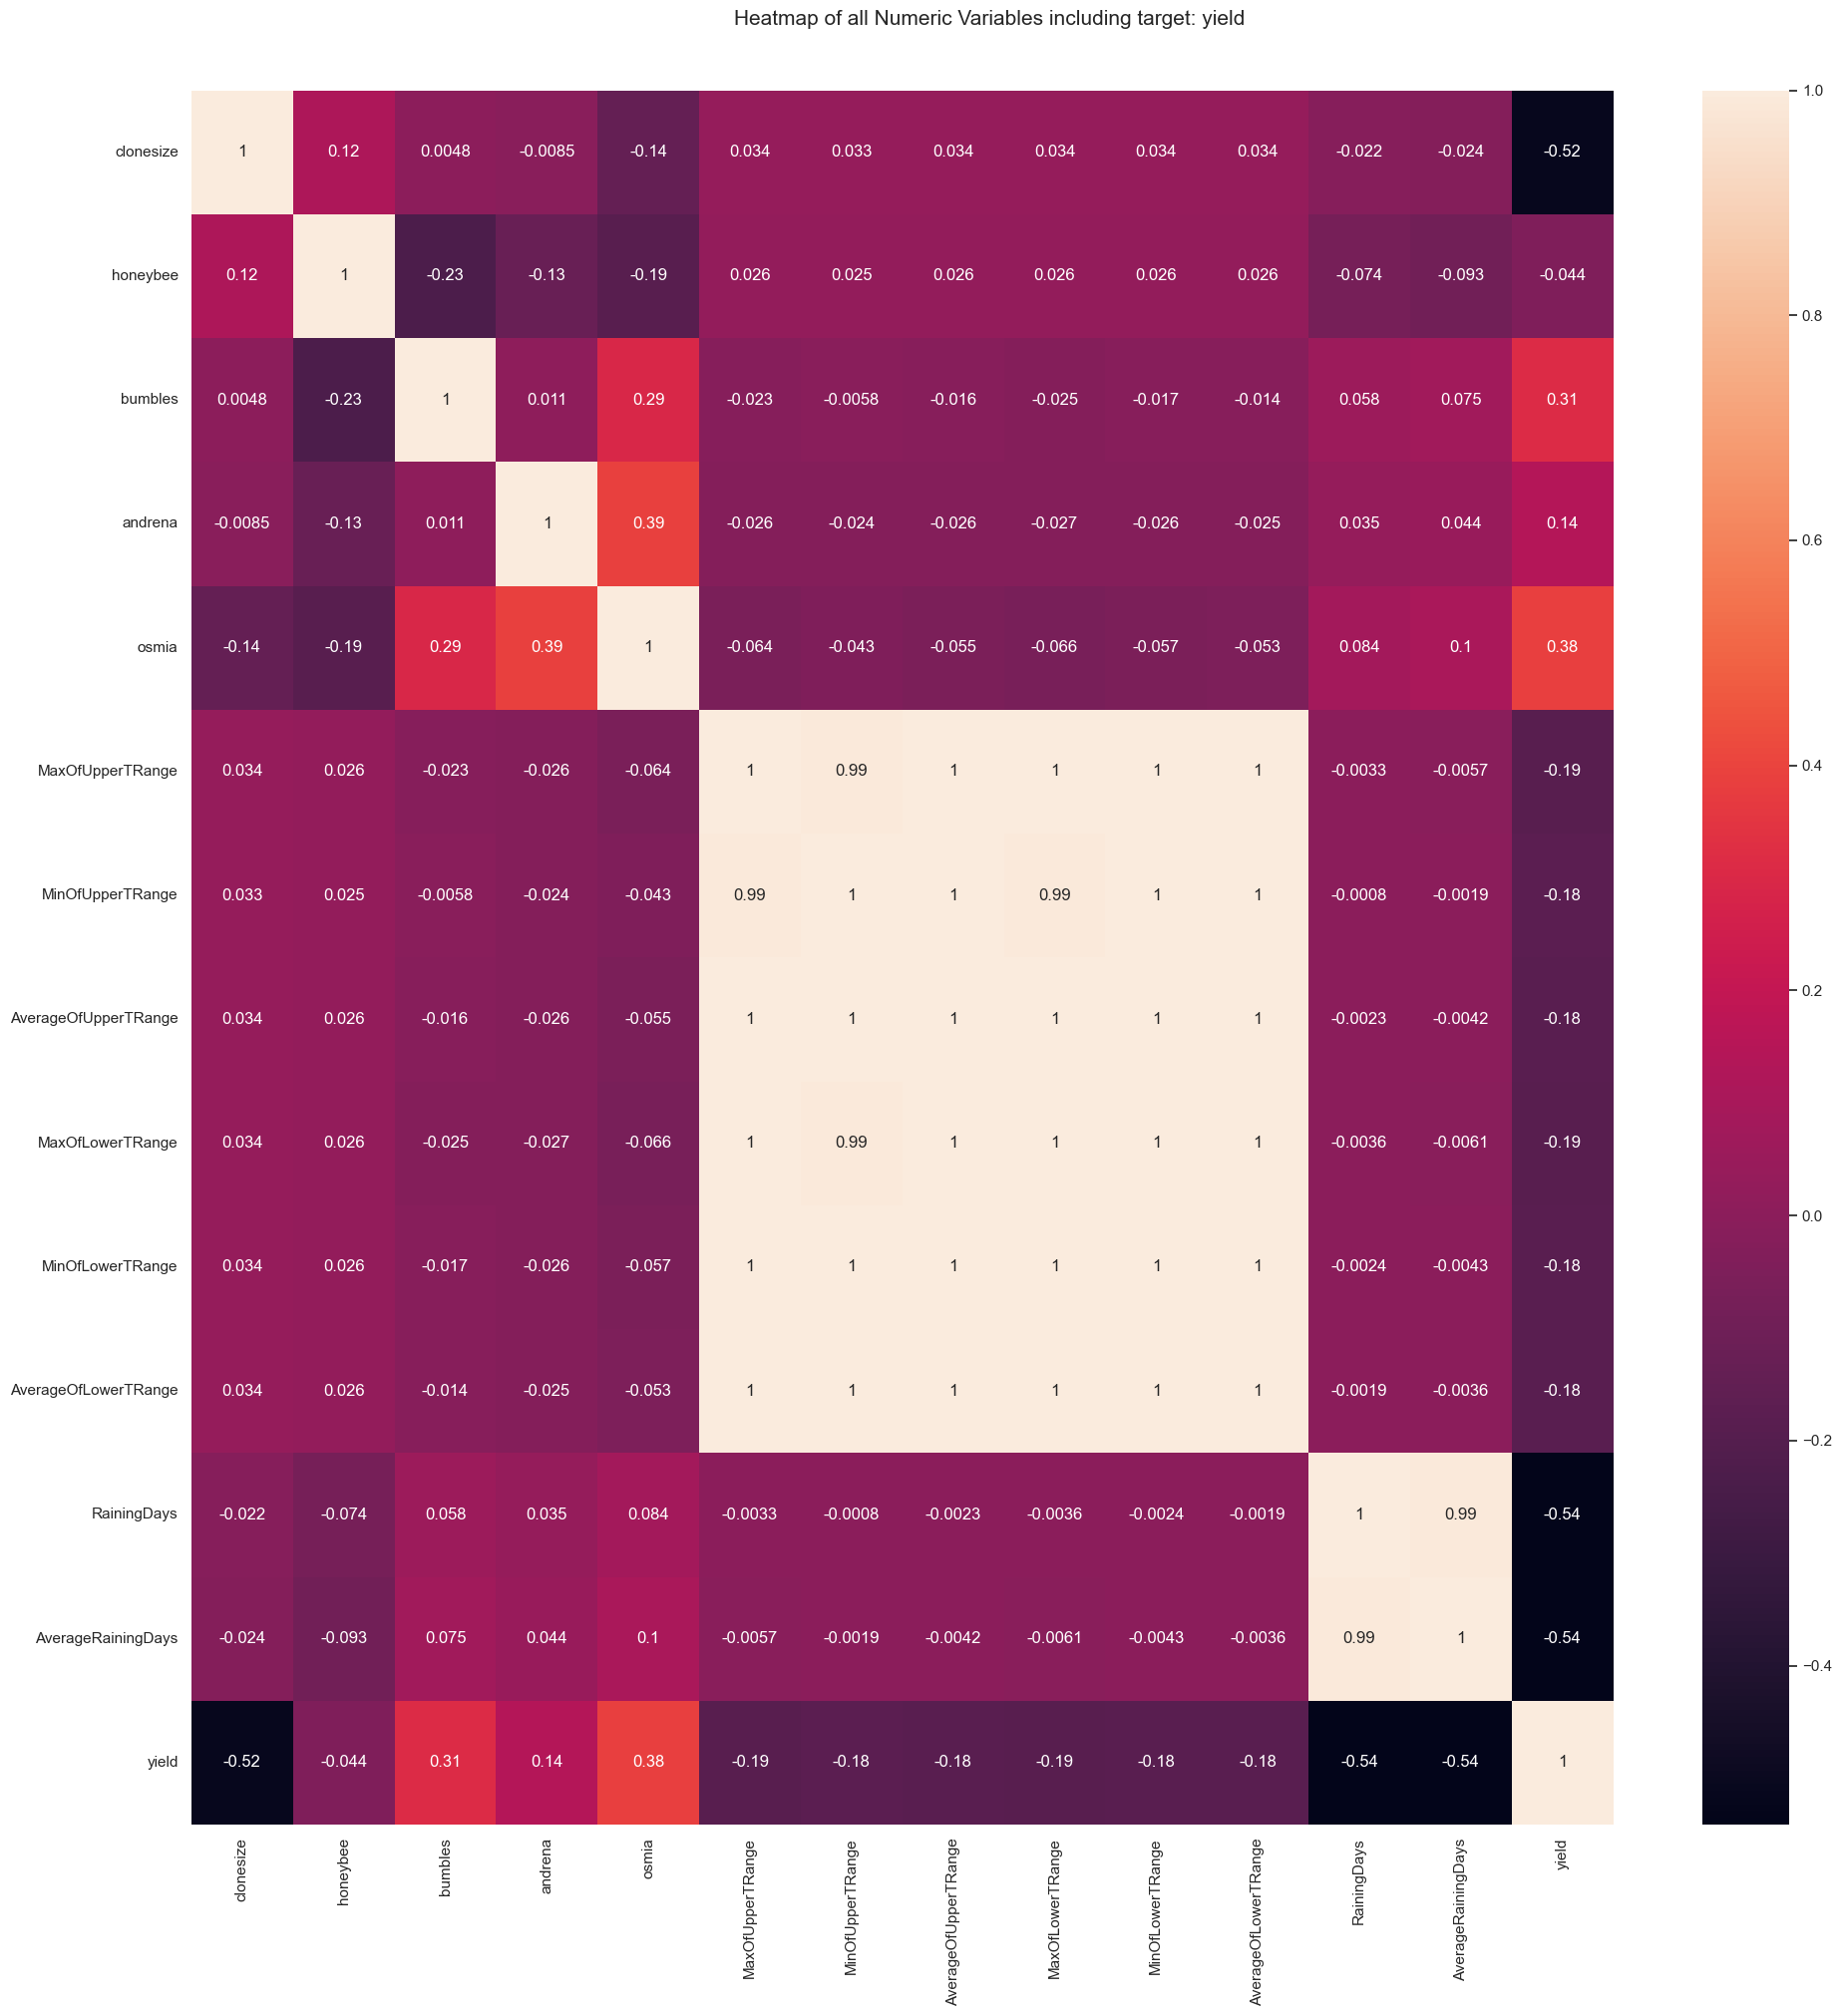

All Plots done
Time to run AutoViz = 36 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [10]:
# Can use autoviz directly as the no. of rows <150000 and columns < 31
av = AutoViz_Class()
df = av.AutoViz(filename = '', depVar = 'yield', dfte = df)

## AutoViz Interpretations feature-wise ##

- Honeybee concentration has no impact on yield, it could probably be a less important feature

- Yield is high for high conc. of andrena and osmia, both impacting yield in a similar pattern

- clonesize almost negatively impacts yield - probably lesser chances of infection if size is small and leading to greater yield
    
- As the observations are quite less, let's retain all outliers

- All 5 Temp. features seem correlated based on heatmap, retain 1
    
- RainingDays is similar to AverageRainingDays, select the least importance one to be removed

- Greater rains have led to small decrease in yields

In [6]:
# Remove highly correlated groups and retain one each
df.drop(columns = ['MinOfUpperTRange','AverageOfUpperTRange','MaxOfLowerTRange','MinOfLowerTRange','AverageOfLowerTRange','AverageRainingDays'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   clonesize         777 non-null    float64
 1   honeybee          777 non-null    float64
 2   bumbles           777 non-null    float64
 3   andrena           777 non-null    float64
 4   osmia             777 non-null    float64
 5   MaxOfUpperTRange  777 non-null    float64
 6   RainingDays       777 non-null    float64
 7   yield             777 non-null    float64
dtypes: float64(8)
memory usage: 48.7 KB


In [7]:
df.duplicated().sum()

0

In [8]:
df.to_csv('Final_DataSet.csv',index=False)

*Storing the final data set for reuse*

In [9]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\ML course\WildBlueberry_YieldPrediction_Project3\Model\Final_DataSet.csv")

In [10]:
y = df['yield']
X = df.drop(columns = 'yield')
X.shape

(777, 7)

(777,)

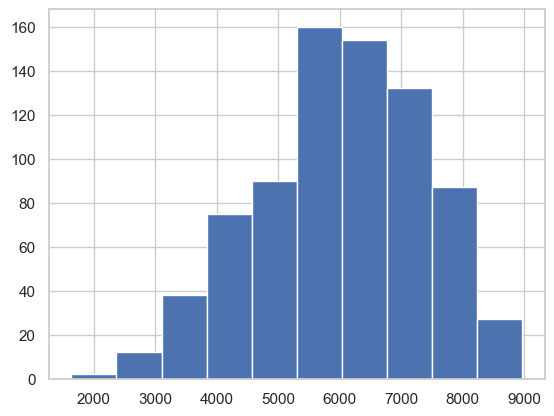

In [11]:
plt.hist(y)
y.shape

In [71]:
# Class looks somewhat balanced (slightly left-skewed, ignoring skewness as of now)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [83]:
X_train

clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
360    12.5       0.25     0.38     0.38    0.50         86.0         
336    12.5       0.25     0.25     0.75    0.63         77.4         
110    12.5       0.25     0.25     0.25    0.63         69.7         
82     12.5       0.25     0.25     0.25    0.38         69.7         
51     12.5       0.25     0.25     0.25    0.25         86.0         
..         ...       ...      ...      ...    ...               ...   
71     12.5       0.25     0.25     0.25    0.38         86.0         
106    12.5       0.25     0.25     0.25    0.63         94.6         
270    12.5       0.25     0.25     0.63    0.50         69.7         
435    12.5       0.25     0.38     0.50    0.75         86.0         
102    12.5       0.25     0.25     0.25    0.63         94.6         

     RainingDays  
360     34.0      
336     34.0      
110      1.0      
82      34.0      
51      16.0      
..           ...  
71      24.0      
106     34.0      
270      1.0      
435     16.0      
102      1.0      

[543 rows x 7 columns]

**Data Normalization**

In [84]:
X_train_norm = pd.DataFrame(normalize(X_train),columns = X_train.columns).astype(dict(X_train.dtypes))
X_test_norm = pd.DataFrame(normalize(X_test),columns = X_test.columns).astype(dict(X_test.dtypes))
X_train_norm

clonesize  honeybee   bumbles   andrena    osmia   MaxOfUpperTRange  \
0    0.133946   0.002679  0.004072  0.004072  0.005358      0.921548       
1    0.146260   0.002925  0.002925  0.008776  0.007372      0.905645       
2    0.176496   0.003530  0.003530  0.003530  0.008895      0.984141       
3    0.159127   0.003183  0.003183  0.003183  0.004837      0.887292       
4    0.141458   0.002829  0.002829  0.002829  0.002829      0.973228       
..         ...       ...       ...       ...       ...               ...   
538  0.138644   0.002773  0.002773  0.002773  0.004215      0.953874       
539  0.123394   0.002468  0.002468  0.002468  0.006219      0.933846       
540  0.176493   0.003530  0.003530  0.008895  0.007060      0.984123       
541  0.141451   0.002829  0.004300  0.005658  0.008487      0.973180       
542  0.130985   0.002620  0.002620  0.002620  0.006602      0.991297       

     RainingDays  
0     0.364333    
1     0.397828    
2     0.014120    
3     0.432825    
4     0.181066    
..           ...  
538   0.266197    
539   0.335632    
540   0.014119    
541   0.181057    
542   0.010479    

[543 rows x 7 columns]

In [90]:
eval_set = [(X_train_norm,y_train),(X_test_norm, y_test)]

## Baseline Modeling ##

In [14]:
def tune(objective):
    study = optuna.create_study(direction = 'minimize')
    # Each study is given a timeout in seconds
    study.optimize(objective,n_trials = 100, timeout = 600)
    print ('Best rmse is ', study.best_value, 'Best parameters are ',study.best_params)

In [17]:
# ** param is used when the no. of arguments to be passed is unknown
# rmse/metric has to be returned, else optuna won't work
# colsample_bylevel is the percentage of features taken for each split, features are selected randomly each time
def cb_objective(trial):
    param = {
        "objective": "RMSE",
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        "learning_rate": trial.suggest_float('learning_rate', 0.01,0.1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 10),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        # bootstrap type determines the way a split is chosen
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )}
    if param["bootstrap_type"] == "Bayesian":
        # if temp is 0, all instances are chosen an equal weight
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    cbr = CatBoostRegressor(**param)
    # After 20 consecutive rounds of no improvement, the model stops fittings
    cbr.fit(X_train_norm, y_train, verbose=0, early_stopping_rounds=20)

    preds = cbr.predict(X_test_norm)

    rmse = root_mean_squared_error(y_test, preds)
    return rmse

In [18]:
tune(cb_objective)
# Best rmse is  261.0755883208565
# Best parameters are  {'colsample_bylevel': 0.9900778201288263, 'learning_rate': 0.0355658205147882, 'l2_leaf_reg': 10, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}

[I 2024-06-08 12:29:46,830] A new study created in memory with name: no-name-55a045f4-22ef-48bc-8974-4fa78b91e9bb
[I 2024-06-08 12:29:49,714] Trial 0 finished with value: 324.52414437234563 and parameters: {'colsample_bylevel': 0.23954181028341998, 'learning_rate': 0.01205616044562038, 'l2_leaf_reg': 8, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6738684800604974}. Best is trial 0 with value: 324.52414437234563.
[I 2024-06-08 12:29:50,299] Trial 1 finished with value: 365.967271873885 and parameters: {'colsample_bylevel': 0.8494182978901578, 'learning_rate': 0.0648452814306319, 'l2_leaf_reg': 7, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.929572306946183}. Best is trial 0 with value: 324.52414437234563.
[I 2024-06-08 12:29:55,591] Trial 2 finished with value: 278.8952986177245 and parameters: {'colsample_bylevel': 0.2671957164180244, 'learning_rate': 0.08473713256210771, 'l2_leaf_reg': 8, 'depth': 

Best rmse is  261.0755883208565 Best parameters are  {'colsample_bylevel': 0.9900778201288263, 'learning_rate': 0.0355658205147882, 'l2_leaf_reg': 10, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}


In [93]:
def xgb_objective(trial):
    param = {    
        "objective": "reg:squarederror",
        "verbosity": 0,        
        # use exact when data set is small, else approx
        "tree_method": "exact",
        # linear is for linear reg, gbtree and dart are tree-based models
        # DART uses the concept of drop-outs
        "booster": trial.suggest_categorical("booster", ['gblinear','gbtree','dart']),
        # alpha is l1 reg
        "reg_alpha": trial.suggest_float("reg_alpha",1e-8, 1, log = True),
        # lambda is l2 reg
        "reg_lambda": trial.suggest_float("reg_lambda",1e-8, 1, log = True),        
        # : of training instances for growing the trees
        "subsample": trial.suggest_float("subsample", 0.1, 1),
        # % of random selection of features while constructing each tree
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
        # For log the minimum value isn greater than 0
        # eta/learning_rate
        param["eta"] = trial.suggest_float("eta", 1e-9, 1, log=True)
        # defines how selective/conservative the algorithm is. gamma/minimum_split_loss
        param["gamma"] = trial.suggest_float("gamma", 1e-9, 1.0, log=True)
        # grow_policy is the way nodes are split, depthwise = nodes closed to the root, lossguide = the nodes with the highest loss change
        # default is depthwise, can be changed if tree-method is hist or approx
        #param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if param["booster"] == "dart":
    # if uniform trees are dropped randomly else based on the weights
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        # type of normalization, default is tree
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-9, 1.0, log=True)
        # skip_drop is the probability at which the drops are skipped
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-9, 1.0, log=True)

    xgbr = XGBRegressor(**param)

    xgbr.fit(X_train_norm, y_train)

    preds = xgbr.predict(X_test_norm)

    mse = mean_squared_error(y_test, preds)
    return mse

In [94]:
tune(xgb_objective)
# Best rmse is  285.68
# Best parameters are  {'booster': 'gbtree', 'reg_alpha': 0.46242159153557466, 'reg_lambda': 0.6762625237517199, 'subsample': 0.5171361757757986, 'colsample_bytree': 0.8167227185597798, 'colsample_bylevel': 0.8060527205211309, 'colsample_bynode': 0.571778450657286, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.17025121385635744, 'gamma': 1.770404474266103e-05}

[I 2024-06-08 16:34:19,572] A new study created in memory with name: no-name-e2d5be00-5db9-4ece-aab0-b34458bf112f
[I 2024-06-08 16:34:19,688] Trial 0 finished with value: 108401.14341347764 and parameters: {'booster': 'gbtree', 'reg_alpha': 0.007139738453393298, 'reg_lambda': 1.9066101547927673e-05, 'subsample': 0.7498010381838102, 'colsample_bytree': 0.34759709279198703, 'colsample_bylevel': 0.5407904950788601, 'colsample_bynode': 0.4800367182574192, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.07167323322928405, 'gamma': 3.462513315074169e-09}. Best is trial 0 with value: 108401.14341347764.
[I 2024-06-08 16:34:20,201] Trial 1 finished with value: 36669334.68208298 and parameters: {'booster': 'dart', 'reg_alpha': 0.010636625777349945, 'reg_lambda': 0.0002939433603025001, 'subsample': 0.6692106008520357, 'colsample_bytree': 0.3124752508462062, 'colsample_bylevel': 0.3338503768900689, 'colsample_bynode': 0.27536875630649543, 'max_depth': 8, 'min_child_weight': 5, 'eta': 6.1258077951

Best rmse is  81614.32698522024 Best parameters are  {'booster': 'gbtree', 'reg_alpha': 0.46242159153557466, 'reg_lambda': 0.6762625237517199, 'subsample': 0.5171361757757986, 'colsample_bytree': 0.8167227185597798, 'colsample_bylevel': 0.8060527205211309, 'colsample_bynode': 0.571778450657286, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.17025121385635744, 'gamma': 1.770404474266103e-05}


## Model Selection and Tuning ##

In [95]:
cat = CatBoostRegressor()

In [96]:
parameters = {'colsample_bylevel': 0.9900778201288263, 'learning_rate': 0.0355658205147882, 'l2_leaf_reg': 10, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}

In [101]:
cat.set_params(**parameters)

In [103]:
cat.fit(X_train_norm,y_train, eval_set=eval_set)

0:	learn: 1309.8460235	test: 1309.8460235	test1: 1386.6279579	best: 1386.6279579 (0)	total: 63.4ms	remaining: 1m 3s
1:	learn: 1285.8992736	test: 1285.8992736	test1: 1362.1458312	best: 1362.1458312 (1)	total: 113ms	remaining: 56.6s
2:	learn: 1263.7153568	test: 1263.7153568	test1: 1339.2275501	best: 1339.2275501 (2)	total: 158ms	remaining: 52.4s
3:	learn: 1244.0593576	test: 1244.0593576	test1: 1318.9068384	best: 1318.9068384 (3)	total: 205ms	remaining: 51.1s
4:	learn: 1221.5838646	test: 1221.5838646	test1: 1295.4562546	best: 1295.4562546 (4)	total: 247ms	remaining: 49.2s
5:	learn: 1202.0684387	test: 1202.0684387	test1: 1274.7747256	best: 1274.7747256 (5)	total: 295ms	remaining: 48.8s
6:	learn: 1184.2359397	test: 1184.2359397	test1: 1257.9913571	best: 1257.9913571 (6)	total: 344ms	remaining: 48.8s
7:	learn: 1163.2919943	test: 1163.2919943	test1: 1236.2264478	best: 1236.2264478 (7)	total: 389ms	remaining: 48.2s
8:	learn: 1144.3454328	test: 1144.3454328	test1: 1216.7643111	best: 1216.764311

In [125]:
# It still has the potential to learn, let's decrease the learning_rate
results = cat.get_evals_result()
results

{'learn': {'RMSE': [1309.846023537903,
   1285.8992736459381,
   1263.7153567644134,
   1244.0593575565663,
   1221.583864625715,
   1202.068438694052,
   1184.2359396851018,
   1163.2919942513504,
   1144.3454327764698,
   1125.8779640339783,
   1105.2118794992832,
   1089.038932755355,
   1071.2074595399588,
   1055.3678051750567,
   1037.5363719578677,
   1020.6418556970493,
   1006.9225666412294,
   990.4819117562033,
   973.499807617381,
   958.0402765308836,
   941.4414281537514,
   927.2250079924206,
   914.3208436979572,
   899.9516158537328,
   886.6263228646491,
   874.6519139626804,
   862.8850325881075,
   850.8678159109343,
   839.4686649726473,
   827.5292504429542,
   815.0939251411608,
   805.3902965756364,
   794.656757455845,
   783.3513755664055,
   772.7848471072455,
   761.4486880843981,
   752.6296354916141,
   742.2766322230295,
   731.8734109881146,
   722.7429209937484,
   713.532954168434,
   704.3103234935919,
   696.0795690427278,
   687.4360857675284,
   67

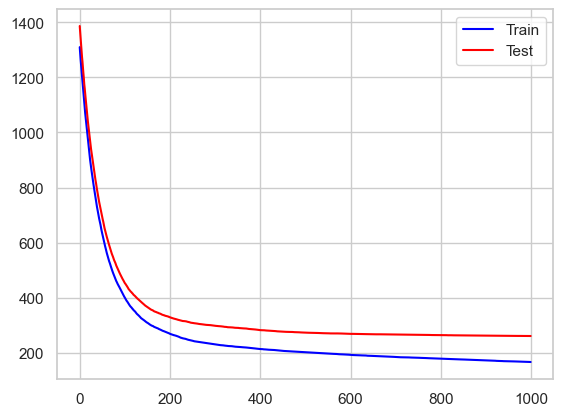

In [134]:
plt.plot(results['validation_0']['RMSE'], color = 'blue')
plt.plot(results['validation_1']['RMSE'], color = 'red')
plt.legend(['Train','Test'])

<BarContainer object of 7 artists>

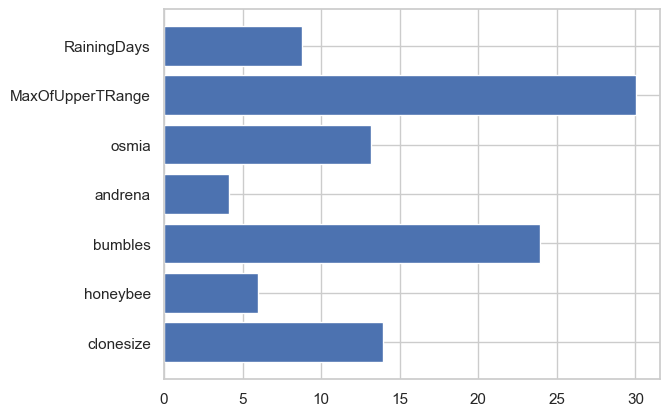

In [133]:
plt.barh(X_train.columns,cat.feature_importances_)

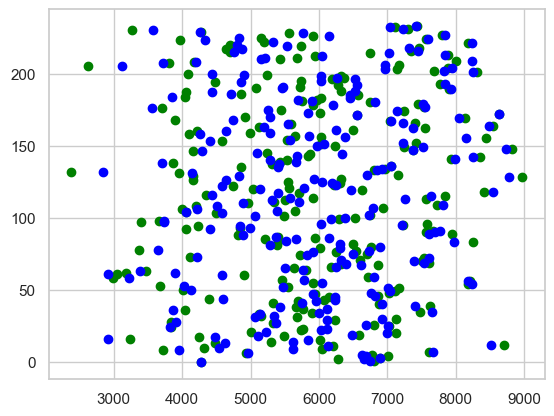

In [135]:
preds = cat.predict(X_test_norm)
plt.scatter(y_test,range(len(y_test)), c = 'green')
plt.scatter(preds,range(len(preds)), c = 'blue')

## Explainable AI ##

In [136]:
shap.initjs()

In [137]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_train_norm)
expected_value = explainer.expected_value

In [138]:
shap.plots.force(shap_values)

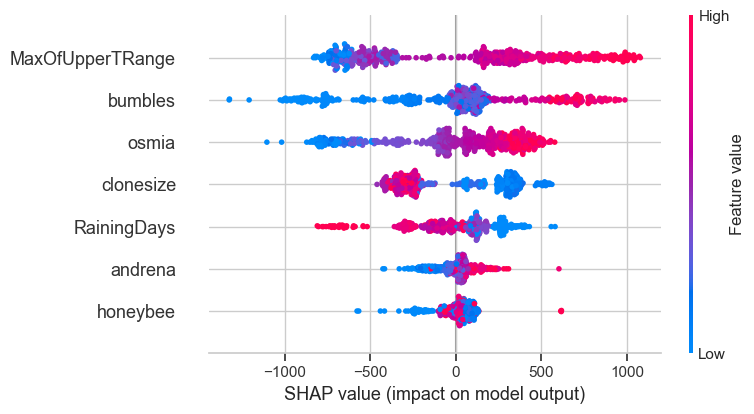

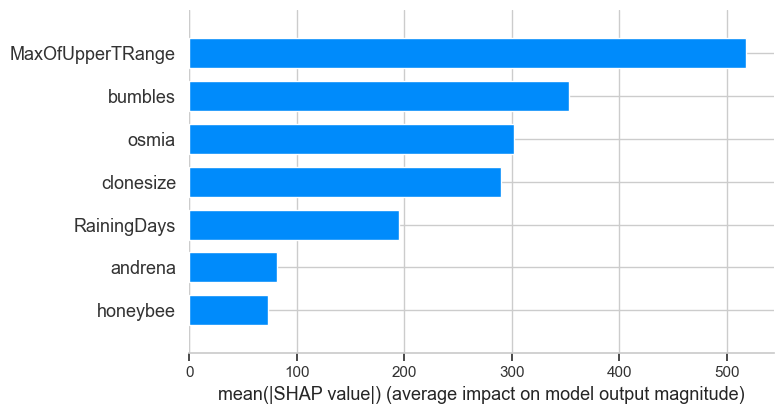

In [139]:
shap.summary_plot(shap_values,X_train_norm)
shap.summary_plot(shap_values,X_train_norm, plot_type = 'bar')

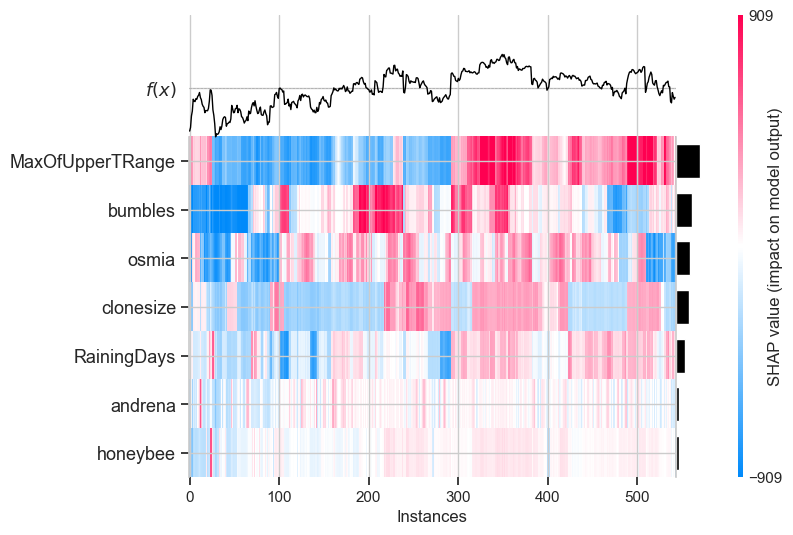

In [141]:
shap.plots.heatmap(shap_values)

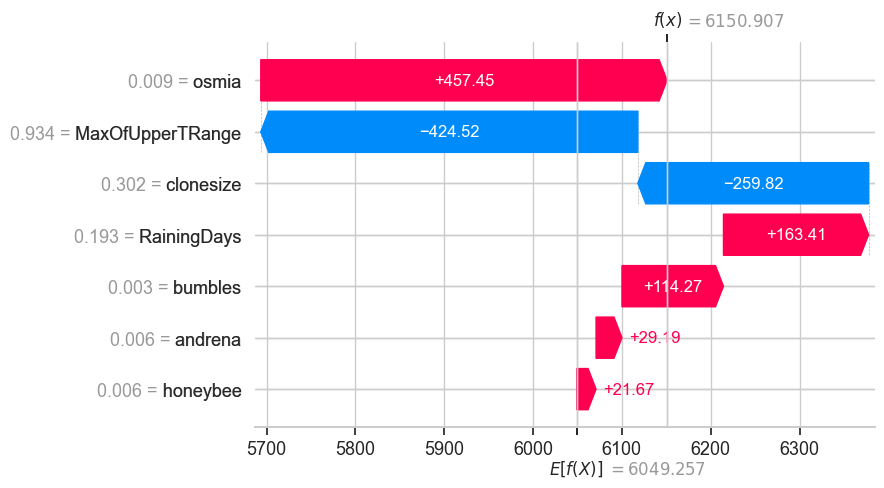

In [142]:
#for single observations
shap.plots.waterfall(shap_values[10])

## Saving the model ##

In [143]:
joblib.dump(cat,'CatBoostRegressor_model.joblib')

['CatBoostRegressor_model.joblib']

In [144]:
model = joblib.load('CatBoostRegressor_model.joblib')

In [145]:
model.predict(X_test_norm.iloc[0])

4277.907616564109